In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.9 MB/s eta 0:00:00


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Epoch 1/10
270/270 [==============================] - 27s 93ms/step - loss: 1.0168 - accuracy: 0.4478 - val_loss: 0.9668 - val_accuracy: 0.5031
Epoch 2/10
270/270 [==============================] - 24s 89ms/step - loss: 0.9604 - accuracy: 0.5144 - val_loss: 0.9466 - val_accuracy: 0.5167
Epoch 3/10
270/270 [==============================] - 24s 91ms/step - loss: 0.9310 - accuracy: 0.5366 - val_loss: 0.9135 - val_accuracy: 0.5281
Epoch 4/10
270/270 [==============================] - 25s 91ms/step - loss: 0.9079 - accuracy: 0.5549 - val_loss: 0.9036 - val_accuracy: 0.5406
Epoch 5/10
270/270 [==============================] - 25s 93ms/step - loss: 0.8845 - accuracy: 0.5735 - val_loss: 0.8776 - val_accuracy: 0.5604
Epoch 6/10
270/270 [==============================] - 25s 92ms/step - loss: 0.8558 - accuracy: 0.5905 - val_loss: 0.8773 - val_accuracy: 0.5531
Epoch 7/10
270/270 [==============================] - 25s 91ms/step - loss: 0.8331 - accuracy: 0.6083 - val_loss: 0.8693 - val_accuracy:

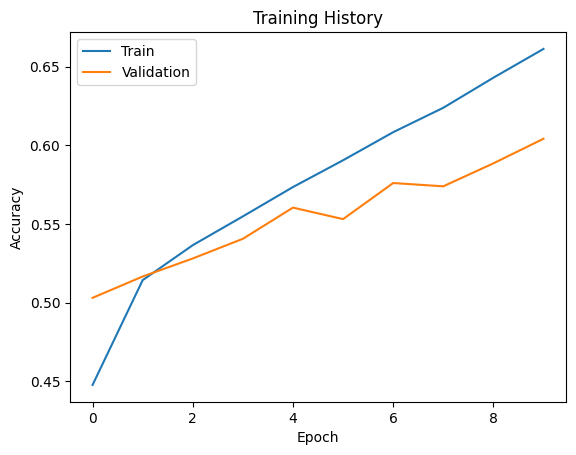

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import csv
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Load BERTtiny tokenizer and model
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
model = TFBertModel.from_pretrained('prajjwal1/bert-tiny', from_pt=True)

# Load dataset
d = pd.read_csv('/content/FinalTrainingOnlyCleaned2 (2).tsv', sep="\t", header=None, nrows=12000)

x = d[1]
y = d[2]
y = list(y)
x = list(x)

# Preprocess data
for i in range(len(x)):
    if type(x[i]) == float:
        x[i] = ""
        y[i] = 1

y = np.array(y)
sentences = x

# Tokenize input sentences
tokenized = tokenizer(sentences, padding=True, return_tensors='tf')

# Obtain BERT embeddings
output = model(tokenized)

# Get LSTM model input from BERT embeddings
X_train = output.last_hidden_state.numpy()
Y_train = y

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Define LSTM model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile and train LSTM model
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_lstm.fit(X_train, Y_train, epochs=10, validation_split=0.1)

# Evaluate LSTM model
test_loss, test_acc = model_lstm.evaluate(X_test, Y_test)
y_pred = model_lstm.predict(X_test)

# Print evaluation metrics
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Classification Report:\n', classification_report(Y_test, y_pred.argmax(axis=1)))
print('Confusion Matrix:\n', confusion_matrix(Y_test, y_pred.argmax(axis=1)))

# Plot training history
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
